# <center> Recommender System </center>

## Preparation

Connect to drive (if needed)

In [514]:
import os
import tensorflow as tf
from tensorflow.python.client import device_lib

DRIVE_DIR = ""
USING_DRIVE = False
if USING_DRIVE:
    # from google.colab import drive
    # drive.mount('/content/drive')
    DRIVE_DIR = "drive/My Drive/Bangkit/"

# Check GPU
devices = tf.config.experimental.list_physical_devices()
for device in devices:
    print(device)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


Constants

In [515]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

LOG_NAME = "recommender-small-simple-128batch"
REMARK = "Try current best model 128batch"
BATCH_SIZE = 128
LEARNING_RATE = 1e-6
EPOCH = 300
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
LOSS_FN = tf.keras.losses.MeanAbsoluteError()

Log dir

In [516]:
DETAIL_DIR = os.path.join(DRIVE_DIR, "log/detail/")
MODEL_DIR = os.path.join(DRIVE_DIR, "log/model/savedmodel/")
KERAS_DIR = os.path.join(DRIVE_DIR, "log/model/keras/")
PLOT_DIR = os.path.join(DRIVE_DIR, "log/plot")
SUMMARY_DIR = os.path.join(DRIVE_DIR, "log/model/summary/")

if (os.path.exists(os.path.join(MODEL_DIR, LOG_NAME)) or 
    os.path.exists(os.path.join(KERAS_DIR, LOG_NAME)) or
    os.path.exists(os.path.join(PLOT_DIR, LOG_NAME)) or
    os.path.exists(os.path.join(SUMMARY_DIR, LOG_NAME)) or
    os.path.exists(os.path.join(DETAIL_DIR, LOG_NAME))):
    raise FileExistsError


## Data Extraction

### Load data from CSV

Not using user data for a while

Data is generated randomly using Excel

In [517]:
DATA_DIR = os.path.join(DRIVE_DIR, "data/synt_data_smaller_dataset/")
INFLUENCER_FILE = os.path.join(DATA_DIR, "data_content_influencer_categ.csv")
OWNER_FILE = os.path.join(DATA_DIR, "data_content_owner_categ.csv")
HISTORY_FILE = os.path.join(DATA_DIR, "historical_data.csv")

df_influencer = pd.read_csv(INFLUENCER_FILE)
# df_owner = pd.read_csv(OWNER_FILE)
df_history = pd.read_csv(HISTORY_FILE)

### Data Exploration

In [518]:
df_influencer.head(5)

,id,insta_follower,tiktok,youtube,categories,avg_rating,pricing_LOW,pricing_BELOW_AVG,pricing_AVG,pricing_ABOVE_AVG,pricing_HIGH
0,1723,6018900,8078640,15046770,"Category 8,Category 2",9.37,0,0,1,1,1
1,82,23809950,35177250,44279670,"Category 4,Category 2,Category 1,Category 8,Ca...",9.26,0,0,1,1,1
2,296,3427860,5198670,5264340,"Category 6,Category 1,Category 4,Category 5",9.25,0,0,1,1,0
3,127,20207160,38229630,74752350,"Category 7,Category 6",9.17,0,0,1,1,1
4,137,4537980,8215080,13298910,"Category 6,Category 1,Category 4,Category 5",9.16,0,0,1,1,1


In [519]:
df_influencer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3532 entries, 0 to 3531
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 3532 non-null   int64  
 1   insta_follower     3532 non-null   int64  
 2   tiktok             3532 non-null   int64  
 3   youtube            3532 non-null   int64  
 4   categories         3532 non-null   object 
 5   avg_rating         3532 non-null   float64
 6   pricing_LOW        3532 non-null   int64  
 7   pricing_BELOW_AVG  3532 non-null   int64  
 8   pricing_AVG        3532 non-null   int64  
 9   pricing_ABOVE_AVG  3532 non-null   int64  
 10  pricing_HIGH       3532 non-null   int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 303.7+ KB


In [520]:
df_influencer.describe()

,id,insta_follower,tiktok,youtube,avg_rating,pricing_LOW,pricing_BELOW_AVG,pricing_AVG,pricing_ABOVE_AVG,pricing_HIGH
count,3532.000000,3.532000e+03,3.532000e+03,3.532000e+03,3532.000000,3532.000000,3532.000000,3532.000000,3532.000000,3532.000000
mean,2078.235844,1.739045e+06,2.459950e+06,3.416828e+06,7.292537,0.328426,0.488675,0.416761,0.161665,0.114949
std,1403.980694,2.683461e+06,4.010099e+06,5.794205e+06,0.662597,0.469707,0.499943,0.493092,0.368195,0.319006
min,1.000000,5.136000e+04,5.031000e+04,5.532000e+04,2.370000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,900.750000,3.462900e+05,4.563300e+05,6.102900e+05,6.860000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1884.500000,7.468650e+05,1.034235e+06,1.428285e+06,7.330000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3120.500000,1.970962e+06,2.658832e+06,3.725685e+06,7.730000,1.000000,1.000000,1.000000,0.000000,0.000000
max,6227.000000,3.041751e+07,4.039176e+07,7.475235e+07,9.370000,1.000000,1.000000,1.000000,1.000000,1.000000


In [521]:
df_history.head(5)

,own_id,inf_id,star_rating,sentiment_rating
0,2,12,5,1.00
1,2,13,4,0.71
2,2,14,4,0.71
3,2,15,4,0.69
4,2,16,4,0.87


In [522]:
df_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152893 entries, 0 to 152892
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   own_id            152893 non-null  int64  
 1   inf_id            152893 non-null  int64  
 2   star_rating       152893 non-null  int64  
 3   sentiment_rating  152893 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 4.7 MB


In [523]:
df_history.describe()

,own_id,inf_id,star_rating,sentiment_rating
count,152893.000000,152893.000000,152893.000000,152893.000000
mean,2393.766288,1203.203626,4.005932,0.750553
std,1444.328510,1086.898864,0.804511,0.164894
min,2.000000,1.000000,1.000000,0.000000
25%,1077.000000,380.000000,4.000000,0.650000
50%,2403.000000,866.000000,4.000000,0.760000
75%,3692.000000,1763.000000,5.000000,0.870000
max,4975.000000,6227.000000,5.000000,1.000000


## Data Transformation

### Data cleaning

#### Missing value

In [524]:
df_influencer.isnull().sum()

id                   0
insta_follower       0
tiktok               0
youtube              0
categories           0
avg_rating           0
pricing_LOW          0
pricing_BELOW_AVG    0
pricing_AVG          0
pricing_ABOVE_AVG    0
pricing_HIGH         0
dtype: int64

In [525]:
df_history.isnull().sum()

own_id              0
inf_id              0
star_rating         0
sentiment_rating    0
dtype: int64

No missing value

#### Irrelevant Data / Invalid Data

Check if all history has valid influencer and owner ID

In [526]:
df_history["inf_id"].isin(df_influencer["id"]).all()

True

All history data has valid influencer and owner ID

### Data Normalization

Normalize influencer data: Scale follower count and One-hot categories

In [527]:
def one_hot(df, column):
    one_hot = df[column].str.get_dummies()
    col_name = one_hot.columns
    new_name = list(map(lambda name: column + "_" + name, col_name))
    one_hot.rename(columns={k: v for k, v in zip(col_name, new_name)}, inplace=True)

    df = pd.concat([df, one_hot], axis=1)
    df = df.drop(column, axis=1)
    return df


In [528]:
YOUTUBE_HIGH_THRES = 2_000_000
YOUTUBE_LOW_THRES = 100_000
TIKTOK_HIGH_THRES = 2_000_000
TIKTOK_LOW_THRES = 100_000
INSTAGRAM_HIGH_THRES = 1_000_000
INSTAGRAM_LOW_THRES = 50_000

# follower_scaler = MinMaxScaler()

df_inf_norm = df_influencer.copy()
df_inf_norm['avg_rating'] = df_inf_norm[['avg_rating']] / 10
# df_inf_norm[["insta_follower", "tiktok", "youtube"]] = follower_scaler.fit_transform(df_inf_norm[["insta_follower", "tiktok", "youtube"]])

# df_inf_norm = one_hot(df_inf_norm, 'price_category') 

one_hot_categories = df_inf_norm['categories'].str.get_dummies(sep=',')
df_inf_norm = pd.concat([df_inf_norm, one_hot_categories], axis=1)
df_inf_norm = df_inf_norm.drop('categories', axis=1)

youtube_bin = [0, YOUTUBE_LOW_THRES, YOUTUBE_HIGH_THRES, df_inf_norm['youtube'].max()]
tiktok_bin = [0, TIKTOK_LOW_THRES, TIKTOK_HIGH_THRES, df_inf_norm['tiktok'].max()]
insta_bin = [0, INSTAGRAM_LOW_THRES, INSTAGRAM_HIGH_THRES, df_inf_norm['insta_follower'].max()]

df_inf_norm['youtube'] = pd.cut(df_inf_norm['youtube'],bins=youtube_bin, labels=["Low", "Medium", "High"])  
df_inf_norm = one_hot(df_inf_norm, 'youtube') 

df_inf_norm['tiktok'] = pd.cut(df_inf_norm['tiktok'],bins=tiktok_bin, labels=["Low", "Medium", "High"])  
df_inf_norm = one_hot(df_inf_norm, 'tiktok') 

df_inf_norm['insta_follower'] = pd.cut(df_inf_norm['insta_follower'],bins=insta_bin, labels=["Low", "Medium", "High"])  
df_inf_norm = one_hot(df_inf_norm, 'insta_follower') 

df_inf_norm.head()

,id,avg_rating,pricing_LOW,pricing_BELOW_AVG,pricing_AVG,pricing_ABOVE_AVG,pricing_HIGH,Category 1,Category 10,Category 2,...,Category 8,Category 9,youtube_High,youtube_Low,youtube_Medium,tiktok_High,tiktok_Low,tiktok_Medium,insta_follower_High,insta_follower_Medium
0,1723,0.937,0,0,1,1,1,0,0,1,...,1,0,1,0,0,1,0,0,1,0
1,82,0.926,0,0,1,1,1,1,0,1,...,1,0,1,0,0,1,0,0,1,0
2,296,0.925,0,0,1,1,0,1,0,0,...,0,0,1,0,0,1,0,0,1,0
3,127,0.917,0,0,1,1,1,0,0,0,...,0,0,1,0,0,1,0,0,1,0
4,137,0.916,0,0,1,1,1,1,0,0,...,0,0,1,0,0,1,0,0,1,0


Combine star and sentiment rating

In [529]:
STAR_WEIGHT = 0.6
SENTIMENT_WEIGHT = 0.4

df_history["combined_rating"] = STAR_WEIGHT * df_history["star_rating"] / 5 + SENTIMENT_WEIGHT * df_history["sentiment_rating"]
df_history

,own_id,inf_id,star_rating,sentiment_rating,combined_rating
0,2,12,5,1.00,1.000
1,2,13,4,0.71,0.764
2,2,14,4,0.71,0.764
3,2,15,4,0.69,0.756
4,2,16,4,0.87,0.828
...,...,...,...,...,...
152888,4975,546,4,0.77,0.788
152889,4975,408,5,0.95,0.980
152890,4975,158,4,0.88,0.832
152891,4975,874,4,0.83,0.812


In [530]:
rating_count = df_history.groupby("star_rating").count()
rating_count

,own_id,inf_id,sentiment_rating,combined_rating
star_rating,,,,
1,1485,1485,1485,1485
2,4528,4528,4528,4528
3,26534,26534,26534,26534
4,79394,79394,79394,79394
5,40952,40952,40952,40952


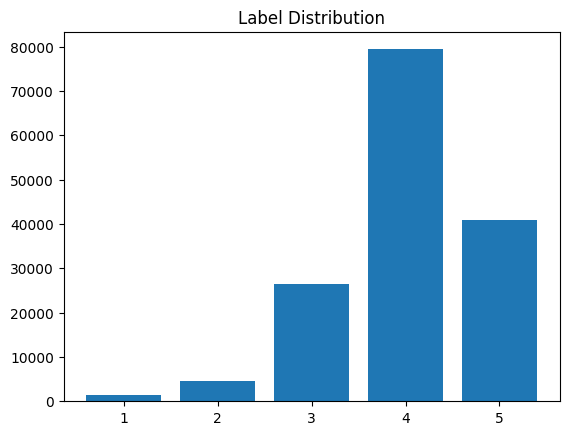

In [531]:
# Chart labels
rating_count = rating_count["own_id"].to_numpy()
ratings = range(1, 6)

# Show pie chart
plt.title("Label Distribution")
plt.bar(x=ratings, height=rating_count)
plt.show()

### Data Splitting

##### Creating user profile

In [532]:
# df_history = df_history.drop(["star_rating", "sentiment_rating"], axis=1)
df_inf_features = pd.merge(df_history, df_inf_norm, left_on='inf_id', right_on='id', how='left')
df_inf_features = df_inf_features.drop(["star_rating", "sentiment_rating"], axis=1)
df_inf_features.head()

,own_id,inf_id,combined_rating,id,avg_rating,pricing_LOW,pricing_BELOW_AVG,pricing_AVG,pricing_ABOVE_AVG,pricing_HIGH,...,Category 8,Category 9,youtube_High,youtube_Low,youtube_Medium,tiktok_High,tiktok_Low,tiktok_Medium,insta_follower_High,insta_follower_Medium
0,2,12,1.000,12,0.882,0,0,1,1,1,...,0,0,1,0,0,1,0,0,1,0
1,2,13,0.764,13,0.781,0,0,1,1,1,...,0,0,1,0,0,1,0,0,1,0
2,2,14,0.764,14,0.843,0,0,1,1,1,...,0,0,1,0,0,1,0,0,1,0
3,2,15,0.756,15,0.719,0,0,1,0,0,...,1,1,1,0,0,1,0,0,1,0
4,2,16,0.828,16,0.780,0,0,1,1,1,...,1,0,1,0,0,1,0,0,1,0


In [533]:
OWNER_FEATURES = df_inf_norm.columns[1:]

# Copy influencer features combined with history data
df_own_norm = df_inf_features.copy()

# Multiply influencer feature with user rating
df_own_norm[OWNER_FEATURES] = df_own_norm[OWNER_FEATURES].mul(df_own_norm['combined_rating'], axis=0) 

# Drop unimportant features
df_own_norm = df_own_norm.drop(["inf_id", "id", "combined_rating"], axis=1)

# Average those with same owner id to make user profile
df_own_norm = df_own_norm.groupby('own_id').mean().reset_index()
df_own_norm.rename(columns={'own_id': 'id'}, inplace=True)

df_own_norm = df_own_norm.drop(['avg_rating'], axis=1)
df_own_norm.head()

,id,pricing_LOW,pricing_BELOW_AVG,pricing_AVG,pricing_ABOVE_AVG,pricing_HIGH,Category 1,Category 10,Category 2,Category 3,...,Category 8,Category 9,youtube_High,youtube_Low,youtube_Medium,tiktok_High,tiktok_Low,tiktok_Medium,insta_follower_High,insta_follower_Medium
0,2,0.033024,0.071675,0.762157,0.509590,0.433301,0.425542,0.001759,0.503988,0.113181,...,0.430542,0.016373,0.751108,0.0,0.128289,0.694771,0.000000,0.184627,0.757663,0.121735
1,13,0.057301,0.135744,0.623603,0.368666,0.286431,0.417197,0.001130,0.483450,0.076165,...,0.418162,0.000000,0.595798,0.0,0.232085,0.532061,0.001111,0.294711,0.632959,0.194925
2,16,0.005261,0.014584,0.796327,0.584996,0.489712,0.478350,0.004669,0.519346,0.033852,...,0.422272,0.000000,0.765743,0.0,0.064093,0.733650,0.000000,0.096187,0.799875,0.029961
3,30,0.044451,0.099986,0.646493,0.415127,0.336169,0.413070,0.016141,0.467507,0.036324,...,0.328282,0.000000,0.626141,0.0,0.161972,0.571352,0.000000,0.216761,0.645507,0.142606
4,34,0.041405,0.107172,0.680172,0.392302,0.324397,0.426741,0.007138,0.449621,0.070328,...,0.444517,0.015112,0.650741,0.0,0.187974,0.607810,0.000000,0.230905,0.689664,0.149052


##### Process feature and label

Influencer features

In [534]:
# Remove ID and labels
df_inf_features = df_inf_features.drop(["own_id", "inf_id", "id"], axis=1)

df_inf_features.head()

,combined_rating,avg_rating,pricing_LOW,pricing_BELOW_AVG,pricing_AVG,pricing_ABOVE_AVG,pricing_HIGH,Category 1,Category 10,Category 2,...,Category 8,Category 9,youtube_High,youtube_Low,youtube_Medium,tiktok_High,tiktok_Low,tiktok_Medium,insta_follower_High,insta_follower_Medium
0,1.000,0.882,0,0,1,1,1,1,0,1,...,0,0,1,0,0,1,0,0,1,0
1,0.764,0.781,0,0,1,1,1,1,0,0,...,0,0,1,0,0,1,0,0,1,0
2,0.764,0.843,0,0,1,1,1,1,0,1,...,0,0,1,0,0,1,0,0,1,0
3,0.756,0.719,0,0,1,0,0,1,0,1,...,1,1,1,0,0,1,0,0,1,0
4,0.828,0.780,0,0,1,1,1,1,0,1,...,1,0,1,0,0,1,0,0,1,0


In [535]:
INFLUENCER_FEATURE_COUNT = len(df_inf_features.drop("combined_rating", axis=1).columns)

Owner features

In [536]:
# Join history and owner data by own_id
df_own_features = pd.merge(df_history.drop(["star_rating", "sentiment_rating"], axis=1), df_own_norm, left_on='own_id', right_on='id', how='left')

df_own_features.head()

,own_id,inf_id,combined_rating,id,pricing_LOW,pricing_BELOW_AVG,pricing_AVG,pricing_ABOVE_AVG,pricing_HIGH,Category 1,...,Category 8,Category 9,youtube_High,youtube_Low,youtube_Medium,tiktok_High,tiktok_Low,tiktok_Medium,insta_follower_High,insta_follower_Medium
0,2,12,1.000,2,0.033024,0.071675,0.762157,0.50959,0.433301,0.425542,...,0.430542,0.016373,0.751108,0.0,0.128289,0.694771,0.0,0.184627,0.757663,0.121735
1,2,13,0.764,2,0.033024,0.071675,0.762157,0.50959,0.433301,0.425542,...,0.430542,0.016373,0.751108,0.0,0.128289,0.694771,0.0,0.184627,0.757663,0.121735
2,2,14,0.764,2,0.033024,0.071675,0.762157,0.50959,0.433301,0.425542,...,0.430542,0.016373,0.751108,0.0,0.128289,0.694771,0.0,0.184627,0.757663,0.121735
3,2,15,0.756,2,0.033024,0.071675,0.762157,0.50959,0.433301,0.425542,...,0.430542,0.016373,0.751108,0.0,0.128289,0.694771,0.0,0.184627,0.757663,0.121735
4,2,16,0.828,2,0.033024,0.071675,0.762157,0.50959,0.433301,0.425542,...,0.430542,0.016373,0.751108,0.0,0.128289,0.694771,0.0,0.184627,0.757663,0.121735


In [537]:
# Remove ID and labels
df_own_features = df_own_features.drop(["own_id", "inf_id", "id"], axis=1)

df_own_features.head()

,combined_rating,pricing_LOW,pricing_BELOW_AVG,pricing_AVG,pricing_ABOVE_AVG,pricing_HIGH,Category 1,Category 10,Category 2,Category 3,...,Category 8,Category 9,youtube_High,youtube_Low,youtube_Medium,tiktok_High,tiktok_Low,tiktok_Medium,insta_follower_High,insta_follower_Medium
0,1.000,0.033024,0.071675,0.762157,0.50959,0.433301,0.425542,0.001759,0.503988,0.113181,...,0.430542,0.016373,0.751108,0.0,0.128289,0.694771,0.0,0.184627,0.757663,0.121735
1,0.764,0.033024,0.071675,0.762157,0.50959,0.433301,0.425542,0.001759,0.503988,0.113181,...,0.430542,0.016373,0.751108,0.0,0.128289,0.694771,0.0,0.184627,0.757663,0.121735
2,0.764,0.033024,0.071675,0.762157,0.50959,0.433301,0.425542,0.001759,0.503988,0.113181,...,0.430542,0.016373,0.751108,0.0,0.128289,0.694771,0.0,0.184627,0.757663,0.121735
3,0.756,0.033024,0.071675,0.762157,0.50959,0.433301,0.425542,0.001759,0.503988,0.113181,...,0.430542,0.016373,0.751108,0.0,0.128289,0.694771,0.0,0.184627,0.757663,0.121735
4,0.828,0.033024,0.071675,0.762157,0.50959,0.433301,0.425542,0.001759,0.503988,0.113181,...,0.430542,0.016373,0.751108,0.0,0.128289,0.694771,0.0,0.184627,0.757663,0.121735


In [538]:
OWNER_FEATURE_COUNT = len(df_own_features.drop("combined_rating", axis=1).columns)

Labels

In [539]:
# Get labels from history data
df_labels = df_history["combined_rating"]
df_labels.head()

0    1.000
1    0.764
2    0.764
3    0.756
4    0.828
Name: combined_rating, dtype: float64

##### Oversampling

In [540]:
df_inf_features = df_inf_features.drop(["combined_rating"], axis=1)
df_own_features = df_own_features.drop(["combined_rating"], axis=1)
df_own_features

,pricing_LOW,pricing_BELOW_AVG,pricing_AVG,pricing_ABOVE_AVG,pricing_HIGH,Category 1,Category 10,Category 2,Category 3,Category 4,...,Category 8,Category 9,youtube_High,youtube_Low,youtube_Medium,tiktok_High,tiktok_Low,tiktok_Medium,insta_follower_High,insta_follower_Medium
0,0.033024,0.071675,0.762157,0.509590,0.433301,0.425542,0.001759,0.503988,0.113181,0.444229,...,0.430542,0.016373,0.751108,0.0,0.128289,0.694771,0.0,0.184627,0.757663,0.121735
1,0.033024,0.071675,0.762157,0.509590,0.433301,0.425542,0.001759,0.503988,0.113181,0.444229,...,0.430542,0.016373,0.751108,0.0,0.128289,0.694771,0.0,0.184627,0.757663,0.121735
2,0.033024,0.071675,0.762157,0.509590,0.433301,0.425542,0.001759,0.503988,0.113181,0.444229,...,0.430542,0.016373,0.751108,0.0,0.128289,0.694771,0.0,0.184627,0.757663,0.121735
3,0.033024,0.071675,0.762157,0.509590,0.433301,0.425542,0.001759,0.503988,0.113181,0.444229,...,0.430542,0.016373,0.751108,0.0,0.128289,0.694771,0.0,0.184627,0.757663,0.121735
4,0.033024,0.071675,0.762157,0.509590,0.433301,0.425542,0.001759,0.503988,0.113181,0.444229,...,0.430542,0.016373,0.751108,0.0,0.128289,0.694771,0.0,0.184627,0.757663,0.121735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152888,0.163202,0.281885,0.506792,0.263843,0.220459,0.345921,0.004834,0.452822,0.073764,0.333076,...,0.335819,0.000000,0.477353,0.0,0.376822,0.404085,0.0,0.450091,0.513619,0.340556
152889,0.163202,0.281885,0.506792,0.263843,0.220459,0.345921,0.004834,0.452822,0.073764,0.333076,...,0.335819,0.000000,0.477353,0.0,0.376822,0.404085,0.0,0.450091,0.513619,0.340556
152890,0.163202,0.281885,0.506792,0.263843,0.220459,0.345921,0.004834,0.452822,0.073764,0.333076,...,0.335819,0.000000,0.477353,0.0,0.376822,0.404085,0.0,0.450091,0.513619,0.340556
152891,0.163202,0.281885,0.506792,0.263843,0.220459,0.345921,0.004834,0.452822,0.073764,0.333076,...,0.335819,0.000000,0.477353,0.0,0.376822,0.404085,0.0,0.450091,0.513619,0.340556


In [541]:
from imblearn.over_sampling import SMOTE
import tensorflow as tf
import random

# Apply oversampling to each input type separately
smote = SMOTE()
df_features = pd.concat([df_inf_features, df_own_features], axis=1)
# df_features, star_ratings = smote.fit_resample(df_features, df_history['star_rating'].values)

In [542]:
# rating_count = np.unique(star_ratings, return_counts=True) 
# rating_count

In [543]:
# # Chart labels
# rating_count = rating_count[1]
# ratings = range(1, 6)

# # Show pie chart
# plt.title("Label Distribution")
# plt.bar(x=ratings, height=rating_count)
# plt.show()

In [544]:
# star_ratings = star_ratings / 5
# sentiment_ratings = star_ratings - 0.1 + 0.2 * random.random()
# df_labels = pd.Series((STAR_WEIGHT * star_ratings + SENTIMENT_WEIGHT * sentiment_ratings).clip(0, 1))

In [545]:
df_data = pd.concat([df_features, df_labels], axis=1).sample(frac=1)
df_data_pos = df_data[df_data["combined_rating"] > 0.4]
df_data_neg = df_data[df_data["combined_rating"] <= 0.4]

In [546]:
df_inf_features_pos = df_data_pos.iloc[:, :INFLUENCER_FEATURE_COUNT]
df_own_features_pos = df_data_pos.iloc[:, INFLUENCER_FEATURE_COUNT:-1]
df_labels_pos = df_data_pos.iloc[:, -1]

In [547]:
df_inf_features_neg = df_data_neg.iloc[:, :INFLUENCER_FEATURE_COUNT]
df_own_features_neg = df_data_neg.iloc[:, INFLUENCER_FEATURE_COUNT:-1]
df_labels_neg = df_data_neg.iloc[:, -1]

##### Generate train, validation, and test dataset (positive and negative)

In [548]:
SHUFFLE_BUFFER = 1000

dataset_pos = tf.data.Dataset.from_tensor_slices(({"inf_feature": df_inf_features_pos, "own_feature": df_own_features_pos}, df_labels_pos))
dataset_pos = dataset_pos.shuffle(SHUFFLE_BUFFER) 
dataset_neg = tf.data.Dataset.from_tensor_slices(({"inf_feature": df_inf_features_neg, "own_feature": df_own_features_neg}, df_labels_neg))
dataset_neg = dataset_neg.shuffle(SHUFFLE_BUFFER) 

print("Positive data:", dataset_pos.element_spec)
print("Count positive data:", dataset_pos.cardinality().numpy())

print("\nNegative data:", dataset_neg.element_spec)
print("Count negative data:", dataset_neg.cardinality().numpy())

Positive data: ({'inf_feature': TensorSpec(shape=(24,), dtype=tf.float64, name=None), 'own_feature': TensorSpec(shape=(23,), dtype=tf.float64, name=None)}, TensorSpec(shape=(), dtype=tf.float64, name=None))
Count positive data: 148337

Negative data: ({'inf_feature': TensorSpec(shape=(24,), dtype=tf.float64, name=None), 'own_feature': TensorSpec(shape=(23,), dtype=tf.float64, name=None)}, TensorSpec(shape=(), dtype=tf.float64, name=None))
Count negative data: 4556


In [549]:
# Generate training, validation, and testing data
POSITIVE_SIZE = dataset_pos.cardinality().numpy()
TRAIN_POS_SIZE = int(POSITIVE_SIZE * 0.9)
VAL_POS_SIZE = int(POSITIVE_SIZE * 0.05)
TEST_POS_SIZE = POSITIVE_SIZE - TRAIN_POS_SIZE - VAL_POS_SIZE

train_dataset_pos = dataset_pos.take(TRAIN_POS_SIZE)
val_dataset_pos = dataset_pos.skip(TRAIN_POS_SIZE).take(VAL_POS_SIZE)
test_dataset_pos = dataset_pos.skip(TRAIN_POS_SIZE + VAL_POS_SIZE).take(TEST_POS_SIZE)

print(f"Positive training dataset has {train_dataset_pos.cardinality().numpy()} data")
print(f"Positive validation dataset has {val_dataset_pos.cardinality().numpy()} data")
print(f"Positive testing dataset has {test_dataset_pos.cardinality().numpy()} data")

Positive training dataset has 133503 data
Positive validation dataset has 7416 data
Positive testing dataset has 7418 data


In [550]:
# Generate training, validation, and testing data
NEGATIVE_SIZE = dataset_neg.cardinality().numpy()
TRAIN_NEG_SIZE = int(NEGATIVE_SIZE * 0.5)
VAL_NEG_SIZE = int(NEGATIVE_SIZE * 0.25)
TEST_NEG_SIZE = NEGATIVE_SIZE - TRAIN_NEG_SIZE - VAL_NEG_SIZE

train_dataset_neg = dataset_neg.take(TRAIN_NEG_SIZE)
val_dataset_neg = dataset_neg.skip(TRAIN_NEG_SIZE).take(VAL_NEG_SIZE)
test_dataset_neg = dataset_neg.skip(TRAIN_NEG_SIZE + VAL_NEG_SIZE).take(TEST_NEG_SIZE)

print(f"Negative training dataset has {train_dataset_neg.cardinality().numpy()} data")
print(f"Negative validation dataset has {val_dataset_neg.cardinality().numpy()} data")
print(f"Negative testing dataset has {test_dataset_neg.cardinality().numpy()} data")

Negative training dataset has 2278 data
Negative validation dataset has 1139 data
Negative testing dataset has 1139 data


In [551]:
train_dataset = train_dataset_pos.concatenate(train_dataset_neg)
val_dataset = val_dataset_pos.concatenate(val_dataset_neg)
test_dataset = test_dataset_pos.concatenate(test_dataset_neg)

print(f"Training dataset has {train_dataset.cardinality().numpy()} data")
print(f"Validation dataset has {val_dataset.cardinality().numpy()} data")
print(f"Testing dataset has {test_dataset.cardinality().numpy()} data")

Training dataset has 135781 data
Validation dataset has 8555 data
Testing dataset has 8557 data


In [552]:
# Batching
REPEAT = 2

train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

##### Check Distribution

In [553]:
def get_label(dataset):
    labels = np.array([])
    for batch in dataset:
        labels = np.concatenate([labels, batch[1].numpy()])

    return labels

In [554]:
bin = [0, 0.2, 0.4, 0.6, 0.8, 1]
bucket = np.digitize(get_label(train_dataset), bin)
np.unique(bucket, return_counts=True)

(array([1, 2, 3, 4, 5, 6], dtype=int64),
 array([  531,  1638, 16515, 59598, 49757,  7742], dtype=int64))

In [555]:
bin = [0, 0.2, 0.4, 0.6, 0.8, 1]
bucket = np.digitize(get_label(val_dataset), bin)
np.unique(bucket, return_counts=True)

(array([1, 2, 3, 4, 5, 6], dtype=int64),
 array([ 256,  831,  945, 3300, 2757,  466], dtype=int64))

In [556]:
bin = [0, 0.2, 0.4, 0.6, 0.8, 1]
bucket = np.digitize(get_label(test_dataset), bin)
np.unique(bucket, return_counts=True)

(array([1, 2, 3, 4, 5, 6], dtype=int64),
 array([ 243,  848,  957, 3350, 2747,  412], dtype=int64))

## Creating Model

Model consists of two neural networks that would be combined with Dot layer. The first neural network has influencer features as input and a vector as an output. The second one has owner features as input and a vector as an output. These two vectors will be combined with Dot layer and produces a single combined rating

In [557]:
VECTOR_SIZE = 32
# tf.random.set_seed(1)

model_influencer = tf.keras.models.Sequential([
    # tf.keras.layers.Dense(units=512, activation='relu'),
    # tf.keras.layers.Dropout(0.8),
    # tf.keras.layers.Dense(units=512, activation='relu'),
    # tf.keras.layers.Dropout(0.9),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.9),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=VECTOR_SIZE, activation='linear'),
])

# create the influencer input and point to the base network
input_influencer = tf.keras.layers.Input(shape=(INFLUENCER_FEATURE_COUNT), name="inf_feature")
vi = model_influencer(input_influencer)
vi = tf.linalg.l2_normalize(vi, axis=1)

model_owner = tf.keras.models.Sequential([
    # tf.keras.layers.Dense(units=512, activation='relu'),
    # tf.keras.layers.Dropout(0.8),
    # tf.keras.layers.Dense(units=512, activation='relu'),
    # tf.keras.layers.Dropout(0.9),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.9),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.9),
    tf.keras.layers.Dense(units=VECTOR_SIZE, activation='linear'),
])

# create the owner input and point to the base network
input_owner = tf.keras.layers.Input(shape=(OWNER_FEATURE_COUNT), name="own_feature")
vo = model_owner(input_owner)
vo = tf.linalg.l2_normalize(vo, axis=1)

# compute the dot product of the two vectors vi and vo
output = tf.keras.layers.Dot(axes=1)([vi, vo])

# specify the inputs and output of the model
model = tf.keras.Model([input_influencer, input_owner], output)

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inf_feature (InputLayer)       [(None, 24)]         0           []                               
                                                                                                  
 own_feature (InputLayer)       [(None, 23)]         0           []                               
                                                                                                  
 sequential_12 (Sequential)     (None, 32)           23840       ['inf_feature[0][0]']            
                                                                                                  
 sequential_13 (Sequential)     (None, 32)           23712       ['own_feature[0][0]']            
                                                                                            

In [558]:
import time

start_time = time.time()
model.compile(optimizer= OPTIMIZER, 
              loss=LOSS_FN,
              metrics=["mse", "mae"])

# LOG_NAME = LOG_NAME[:-1]
# model = tf.keras.models.load_model(os.path.join(KERAS_DIR, LOG_NAME))
# LOG_NAME += "I"
history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCH)
end_time = time.time()
training_time = end_time - start_time

OSError: No file or directory found at log/model/keras/recommender-small-simple-128batch

In [ ]:
def plot_history(history, save=False):
    # Extract the loss, MAE, and MSE values from the history object
    loss = history.history['loss']
    mse = history.history['mse']
    mae = history.history['mae']
    val_loss = history.history['val_loss']
    val_mse = history.history['val_mse']
    val_mae = history.history['val_mae']

    # Create a figure and set up the subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))

    # Plot the loss history
    plt.title(REMARK)
    ax1.plot(loss, label='Loss')
    ax1.plot(val_loss, label='Val Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot the MSE history
    ax2.plot(mse, label='MSE')
    ax2.plot(val_mse, label='Val MSE')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('MSE')
    ax2.legend()

    # Plot the MAE history
    ax3.plot(mae, label='MAE')
    ax3.plot(val_mae, label='Val MAE')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('MAE')
    ax3.legend()

    # Show the plot
    plt.tight_layout()
    if (save):
        if (not os.path.exists(os.path.join(PLOT_DIR, LOG_NAME))):
            plt.savefig(os.path.join(PLOT_DIR, LOG_NAME))
    
    plt.show()

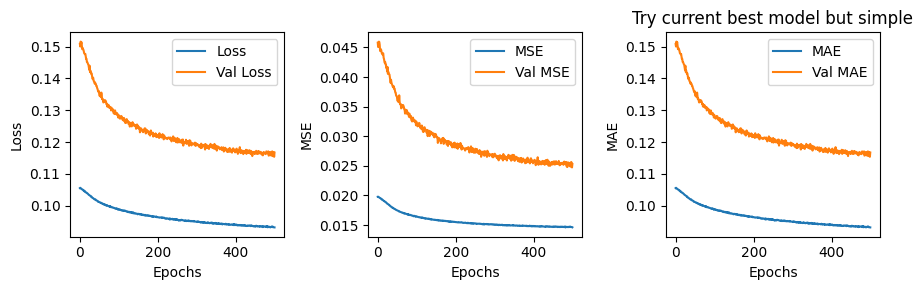

In [ ]:
plot_history(history, save=True)


### Evaluation with test dataset

In [ ]:
test_predict = model.predict(test_dataset)
test_predict

17/17 [==============================] - 0s 2ms/step


array([[0.73602104],
       [0.8103296 ],
       [0.8897763 ],
       ...,
       [0.73544216],
       [0.5892178 ],
       [0.06736124]], dtype=float32)

In [ ]:
test_labels = get_label(test_dataset)
compare_test = pd.concat([pd.DataFrame(test_predict, columns=["predicted"]), 
                     pd.DataFrame(test_labels, columns=["real"])], axis=1)

compare_test["error"] = abs(compare_test["predicted"] - compare_test["real"])

compare_test

,predicted,real,error
0,0.736021,0.800,0.063979
1,0.810330,0.752,0.058330
2,0.889776,0.776,0.113776
3,0.761063,0.964,0.202937
4,0.952169,0.976,0.023831
...,...,...,...
8552,0.788673,0.216,0.572673
8553,0.661763,0.396,0.265763
8554,0.735442,0.388,0.347442
8555,0.589218,0.376,0.213218


In [ ]:
compare_test[compare_test["error"] > 5e-1]

,predicted,real,error
1826,0.923126,0.404,0.519126
5239,0.970794,0.428,0.542794
6877,0.931535,0.420,0.511535
7428,0.706956,0.136,0.570956
7429,0.690859,0.164,0.526859
...,...,...,...
8521,0.713577,0.140,0.573577
8526,0.680587,0.148,0.532587
8534,0.684777,0.172,0.512777
8549,0.719174,0.200,0.519174


In [ ]:
compare_test["error"].mean()

0.1537435317244905

## Logging

In [ ]:
if (not os.path.exists(os.path.join(MODEL_DIR, LOG_NAME))):
    tf.saved_model.save(model, os.path.join(MODEL_DIR, LOG_NAME))

INFO:tensorflow:Assets written to: log/model/savedmodel/recommender-small-simple-I\assets


INFO:tensorflow:Assets written to: log/model/savedmodel/recommender-small-simple-I\assets


In [ ]:
if (not os.path.exists(os.path.join(KERAS_DIR, LOG_NAME))):
    model.save(os.path.join(KERAS_DIR, LOG_NAME))

INFO:tensorflow:Assets written to: log/model/keras/recommender-small-simple-I\assets


INFO:tensorflow:Assets written to: log/model/keras/recommender-small-simple-I\assets


In [ ]:
def serialize(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        raise TypeError("Object of type {} is not JSON serializable".format(type(obj)))

In [ ]:
import json
from datetime import timedelta

log = {
    "name": LOG_NAME,
    "training_time": str(timedelta(training_time)),
    "remark": REMARK,
    "test_error": compare_test["error"].mean(),
    "results": {
        "last_loss": history.history["loss"][-1],
        "last_mae": history.history["mae"][-1],
        "last_mse": history.history["mse"][-1],
        "last_val_loss": history.history["val_loss"][-1],
        "last_val_mae": history.history["val_mae"][-1],
        "last_val_mse": history.history["val_mse"][-1],
    },
    "hyperparameter": {
        "learning_rate": LEARNING_RATE,
        "epoch": EPOCH,
        "batch_size": BATCH_SIZE,
        "loss_func": tf.keras.losses.serialize(LOSS_FN)["class_name"],
        "optimizer": tf.keras.optimizers.serialize(OPTIMIZER)["class_name"],
    },
    # "data_distribution": {
    #     "positive": POSITIVE_SIZE,
    #     "negative": NEGATIVE_SIZE,
    #     "training_pos": TRAIN_POS_SIZE,
    #     "training_neg": TRAIN_NEG_SIZE,
    # },
    "data_example": {
        "influencer": df_influencer.head().to_dict(),
        "owner": df_own_norm.head().to_dict(),
        "history": df_history.head().to_dict(),
    },
    "eval": {
        "loss": history.history["loss"],
        "mae": history.history["mae"],
        "mse": history.history["mse"],
        "val_loss": history.history["val_loss"],
        "val_mae": history.history["val_mae"],
        "val_mse": history.history["val_mse"],
    }
}
if (not os.path.exists(os.path.join(DETAIL_DIR, LOG_NAME + ".json"))):
    with open(os.path.join(DETAIL_DIR, LOG_NAME + '.json'), 'w') as json_file:
        log = json.dumps(log, default=serialize)
        json_file.write(log)

In [ ]:
summary = model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inf_feature (InputLayer)       [(None, 24)]         0           []                               
                                                                                                  
 own_feature (InputLayer)       [(None, 23)]         0           []                               
                                                                                                  
 sequential_10 (Sequential)     (None, 32)           14624       ['inf_feature[0][0]']            
                                                                                                  
 sequential_11 (Sequential)     (None, 32)           14368       ['own_feature[0][0]']            
                                                                                            

In [ ]:
from contextlib import redirect_stdout

with open(os.path.join(SUMMARY_DIR, LOG_NAME + ".txt"), 'w') as f:
    with redirect_stdout(f):
        print("Influencer Model:")
        model_influencer.summary()
        
        print("\nOwner Model:")
        model_owner.summary()
        
        print("\nFull Model:")
        model.summary()

In [ ]:
Stopper

NameError: name 'Stopper' is not defined

##### Generate train, validation, and test dataset

In [ ]:
SHUFFLE_BUFFER = 1000

dataset = tf.data.Dataset.from_tensor_slices(({"inf_feature": df_inf_features, "own_feature": df_own_features}, df_labels))
dataset = dataset.shuffle(SHUFFLE_BUFFER) 

dataset.element_spec

({'inf_feature': TensorSpec(shape=(24,), dtype=tf.float64, name=None),
  'own_feature': TensorSpec(shape=(23,), dtype=tf.float64, name=None)},
 TensorSpec(shape=(), dtype=tf.float64, name=None))

In [ ]:
# Generate training, validation, and testing data
DATASET_SIZE = dataset.cardinality().numpy()
TRAIN_SIZE = int(DATASET_SIZE * 0.95)
VAL_SIZE = int(DATASET_SIZE * 0.025)
TEST_SIZE = DATASET_SIZE - TRAIN_SIZE - VAL_SIZE

train_dataset = dataset.take(TRAIN_SIZE)
val_dataset = dataset.skip(TRAIN_SIZE).take(VAL_SIZE)
test_dataset = dataset.skip(TRAIN_SIZE + VAL_SIZE).take(TEST_SIZE)

print(f"Training dataset has {train_dataset.cardinality().numpy()} data")
print(f"Validation dataset has {val_dataset.cardinality().numpy()} data")
print(f"Testing dataset has {test_dataset.cardinality().numpy()} data")

Training dataset has 377121 data
Validation dataset has 9924 data
Testing dataset has 9925 data


In [ ]:
# Batching
REPEAT = 2

train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
train_dataset = train_dataset.cache()
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)